In [38]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from scipy.stats import zscore 
from scipy import stats
from scipy.stats import kurtosis
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



start = "2015-01-01"
end = "2025-01-01"


In [4]:
index = yf.download("^GSPC", start="2015-01-01", end="2025-01-01")
vix = yf.download("^VIX", start="2015-01-01", end="2025-01-01")
skew = yf.download("^SKEW", start=start, end=end)



spx = index.add_prefix("SPX_")
vix   = vix.add_prefix("VIX_")
skew  = skew.add_prefix("SKEW_")






C:\Users\maxim\AppData\Local\Temp\ipykernel_25112\1176649704.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  index = yf.download("^GSPC", start="2015-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed
C:\Users\maxim\AppData\Local\Temp\ipykernel_25112\1176649704.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix = yf.download("^VIX", start="2015-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed
C:\Users\maxim\AppData\Local\Temp\ipykernel_25112\1176649704.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  skew = yf.download("^SKEW", start=start, end=end)
[*********************100%***********************]  1 of 1 completed


In [46]:
df = spx.join(vix, how="inner").join(skew, how="inner")

df = df.loc[:, ~df.columns.duplicated()].copy()

df.head()
if isinstance(df.columns, pd.MultiIndex):  # Check if columns are MultiIndex? si je met pas ca, j'ai des problemes de double indexation
    df.columns = [col[0] for col in df.columns] 
df

,SPX_Close,SPX_High,SPX_Low,SPX_Open,SPX_Volume,VIX_Close,VIX_High,VIX_Low,VIX_Open,VIX_Volume,SKEW_Close,SKEW_High,SKEW_Low,SKEW_Open,SKEW_Volume
Date,,,,,,,,,,,,,,,
2015-01-02,2058.199951,2072.360107,2046.040039,2058.899902,2708700000,17.790001,20.139999,17.049999,17.760000,0,128.660004,128.660004,128.660004,128.660004,0
2015-01-05,2020.579956,2054.439941,2017.339966,2054.439941,3799120000,19.920000,21.290001,19.190001,19.190001,0,127.790001,127.790001,127.790001,127.790001,0
2015-01-06,2002.609985,2030.250000,1992.439941,2022.150024,4460110000,21.120001,22.900000,19.520000,20.330000,0,125.269997,125.269997,125.269997,125.269997,0
2015-01-07,2025.900024,2029.609985,2005.550049,2005.550049,3805480000,19.309999,20.719999,19.040001,20.150000,0,123.559998,123.559998,123.559998,123.559998,0
2015-01-08,2062.139893,2064.080078,2030.609985,2030.609985,3934010000,17.010000,18.090000,16.990000,17.930000,0,124.769997,124.769997,124.769997,124.769997,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,6040.040039,6040.100098,5981.439941,5984.629883,1757720000,14.270000,17.040001,14.270000,16.969999,0,180.089996,180.089996,180.089996,180.089996,0
2024-12-26,6037.589844,6049.750000,6007.370117,6024.970215,2904530000,14.730000,15.930000,14.550000,14.990000,0,173.720001,173.720001,173.720001,173.720001,0
2024-12-27,5970.839844,6006.169922,5932.950195,6006.169922,3159610000,15.950000,18.450001,15.290000,15.380000,0,167.919998,167.919998,167.919998,167.919998,0


In [47]:
# on calcule nos features derives des indices  

df['SPX_Return'] = np.log(df['SPX_Close'] / df['SPX_Close'].shift(1)) # return log du s&p500  

df['RealizedVol_21d'] = df['SPX_Return'].rolling(window=21).std()*np.sqrt(252) # vol sur 1 mois  annualisé

df['IV_RV_Spread'] = (df['VIX_Close'] / 100) - df['RealizedVol_21d'] # spread entre vol implicite du vix et vol realisee  

df['VIX_Change'] = df['VIX_Close'].pct_change() # variation du vix  

df['SKEW_Change'] = df['SKEW_Close'].diff() # variation du skew  

df['Abs_Return'] = df['SPX_Return'].abs() # amplitude des mouvements du spx  

df['Vol_Ratio'] = (df['VIX_Close'] / 100) / df['RealizedVol_21d'] # ratio entre vol implicite et vol réalisée  


df = df.dropna()  # on vire les lignes avec des NaN prcq on fait un rolling donc la 1ere ligne saute  


df = df[['SPX_Close','SPX_Open',"SPX_High","SPX_Low",'SPX_Volume', 'VIX_Close','VIX_Open', 'SKEW_Close','SKEW_Open',
         'SPX_Return', 'Abs_Return', 'RealizedVol_21d',
         'IV_RV_Spread', 'VIX_Change', 'SKEW_Change', 'Vol_Ratio']]


df


,SPX_Close,SPX_Open,SPX_High,SPX_Low,SPX_Volume,VIX_Close,VIX_Open,SKEW_Close,SKEW_Open,SPX_Return,Abs_Return,RealizedVol_21d,IV_RV_Spread,VIX_Change,SKEW_Change,Vol_Ratio
Date,,,,,,,,,,,,,,,,
2015-02-03,2050.030029,2022.709961,2050.300049,2022.709961,4615900000,17.330000,18.410000,129.779999,129.779999,0.014336,0.014336,0.180978,-0.007678,-0.108080,-0.199997,0.957575
2015-02-04,2041.510010,2048.860107,2054.739990,2036.719971,4141920000,18.330000,17.820000,126.199997,126.199997,-0.004165,0.004165,0.169203,0.014097,0.057703,-3.580002,1.083315
2015-02-05,2062.520020,2043.449951,2063.550049,2043.449951,3821990000,16.850000,17.290001,127.540001,127.540001,0.010239,0.010239,0.168782,-0.000282,-0.080742,1.340004,0.998329
2015-02-06,2055.469971,2062.280029,2072.399902,2049.969971,4232970000,17.290001,16.290001,125.620003,125.620003,-0.003424,0.003424,0.165366,0.007534,0.026113,-1.919998,1.045561
2015-02-09,2046.739990,2053.469971,2056.159912,2041.880005,3549540000,18.549999,19.160000,129.850006,129.850006,-0.004256,0.004256,0.153966,0.031534,0.072874,4.230003,1.204813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,6040.040039,5984.629883,6040.100098,5981.439941,1757720000,14.270000,16.969999,180.089996,180.089996,0.010982,0.010982,0.137112,0.005588,-0.149583,9.440002,1.040756
2024-12-26,6037.589844,6024.970215,6049.750000,6007.370117,2904530000,14.730000,14.990000,173.720001,173.720001,-0.000406,0.000406,0.136852,0.010448,0.032235,-6.369995,1.076345
2024-12-27,5970.839844,6006.169922,6006.169922,5932.950195,3159610000,15.950000,15.380000,167.919998,167.919998,-0.011117,0.011117,0.140977,0.018523,0.082824,-5.800003,1.131394


In [9]:
df.to_csv(r"C:\Documents\ESILV\A4\Machine Learning\Projet\dataset.csv", sep=';', decimal='.', index=True)



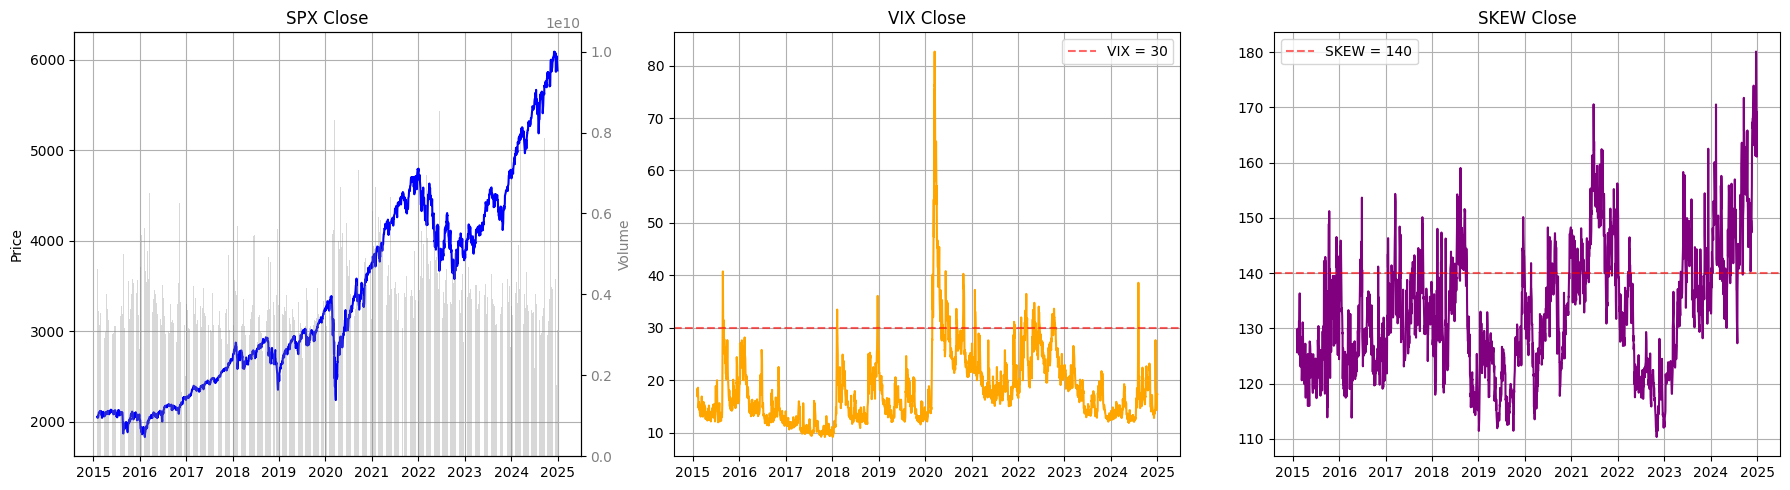

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

#SPX Close + Volume
ax1 = axes[0]
ax1.plot(df.index, df['SPX_Close'], color='blue')
ax1.set_title('SPX Close')
ax1.set_ylabel('Price')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.bar(df.index, df['SPX_Volume'], color='gray', alpha=0.3, width=1)
ax2.set_ylabel('Volume', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

#VIX Close
axes[1].plot(df.index, df['VIX_Close'], color='orange')
axes[1].axhline(30, color='red', linestyle='--', alpha=0.6, label='VIX = 30')
axes[1].set_title('VIX Close')
axes[1].legend()
axes[1].grid(True)

#SKEW Close
axes[2].plot(df.index, df['SKEW_Close'], color='purple')
axes[2].axhline(140, color='red', linestyle='--', alpha=0.6, label='SKEW = 140')
axes[2].set_title('SKEW Close')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

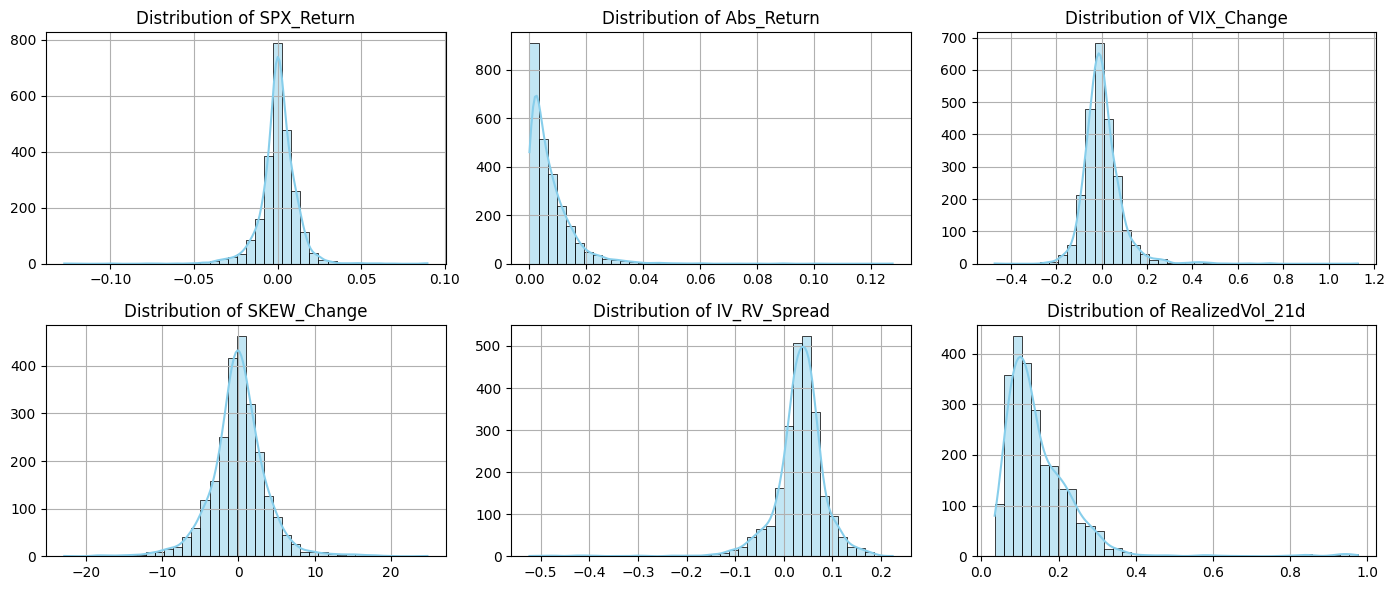

In [ ]:

features = ['SPX_Return', 'Abs_Return', 'VIX_Change', 'SKEW_Change', 'IV_RV_Spread', 'RealizedVol_21d']

fig, axes = plt.subplots(2, 3, figsize=(14, 6))
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.histplot(df[feature], kde=True, bins=40, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].grid(True)

plt.tight_layout()
plt.show()


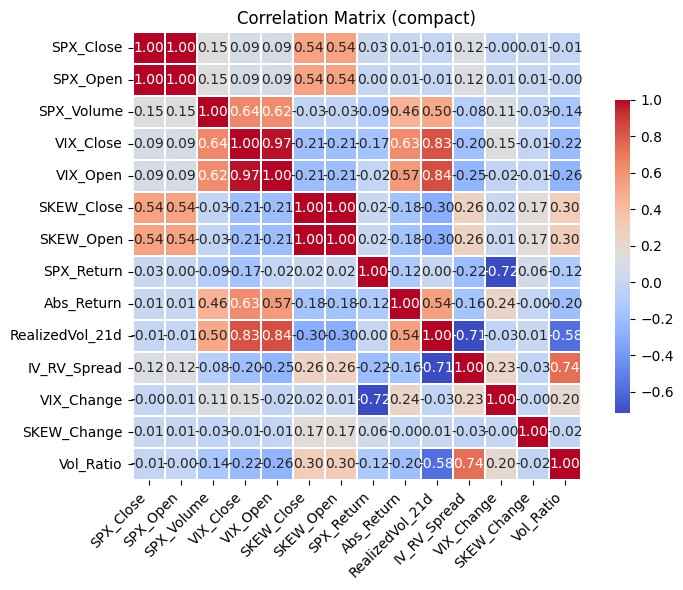

In [22]:
correlation_matrix = df.corr(numeric_only=True)

plt.figure(figsize=(8, 6))  # taille réduite
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    linewidths=0.3,
    cbar_kws={"shrink": 0.7}  # barre de couleur plus fine
)
plt.title("Correlation Matrix (compact)", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



In [ ]:
# List of features to analyze
features = ['SPX_Return', 'Abs_Return', 'VIX_Change', 'SKEW_Change', 'IV_RV_Spread', 'RealizedVol_21d']

skewness = df[features].skew()
kurtosis = df[features].kurt()

summary_stats = pd.DataFrame({
    'Skewness': skewness,
    'Kurtosis': kurtosis
})


z_scores = df[features].apply(zscore)

summary_stats, z_scores.head


(                 Skewness   Kurtosis
 SPX_Return      -0.885713  15.909973
 Abs_Return       4.171348  33.392860
 VIX_Change       2.615304  20.709680
 SKEW_Change      0.096044   4.623366
 IV_RV_Spread    -3.075553  22.424984
 RealizedVol_21d  3.947421  24.487943,
 <bound method NDFrame.head of             SPX_Return  Abs_Return  VIX_Change  SKEW_Change  IV_RV_Spread  \
 Date                                                                        
 2015-02-03    1.216458    0.795912   -1.271291    -0.057408     -0.672582   
 2015-02-04   -0.402879   -0.370891    0.618889    -0.955460     -0.301844   
 2015-02-05    0.857821    0.325885   -0.959593     0.351763     -0.546658   
 2015-02-06   -0.338050   -0.455857    0.258709    -0.514405     -0.413583   
 2015-02-09   -0.410891   -0.360391    0.791861     1.119623     -0.004967   
 ...                ...         ...         ...          ...           ...   
 2024-12-24    0.922891    0.411165   -1.744482     2.503897     -0.446717   
 

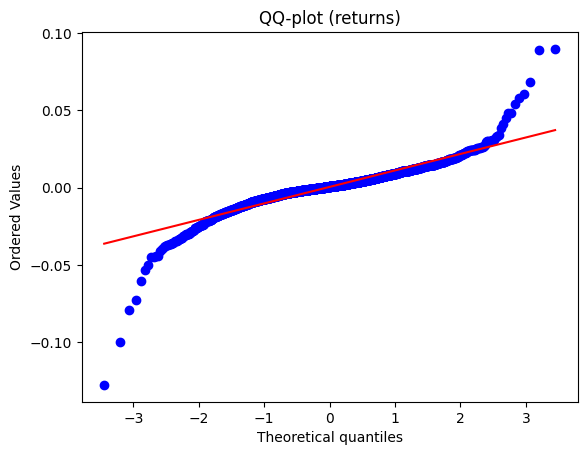

Jarque–Bera: stat=25918.64, p=0


In [ ]:
#QQ-plot + Jarque-Bera
stats.probplot(df["SPX_Return"].dropna(), dist="norm", plot=plt); plt.title("QQ-plot (returns)")
plt.show()
jb_stat, jb_p = stats.jarque_bera(df["SPX_Return"].dropna())
print(f"Jarque–Bera: stat={jb_stat:.2f}, p={jb_p:.3g}")


## Méthode IQR (Écart Interquartile)

### Calcul de l'IQR

IQR = Q3 - Q1

Où :
- Q1 = Premier quartile (25e percentile)
- Q3 = Troisième quartile (75e percentile)

### Détection des valeurs aberrantes

Les valeurs aberrantes sont identifiées selon les critères suivants :

Limite inférieure :

Limite_inf = Q1 - 1.5 × IQR

Limite supérieure :

Limite_sup = Q3 + 1.5 × IQR

Une valeur est considérée comme aberrante si :
- Elle est inférieure à la limite inférieure : x < Q1 - 1.5 × IQR
- Elle est supérieure à la limite supérieure : x > Q3 + 1.5 × IQR

### Valeurs aberrantes extrêmes (optionnel)

Pour des valeurs aberrantes plus extrêmes, on utilise parfois le facteur 3 :

Limite_inf_extrême = Q1 - 3 × IQR

Limite_sup_extrême = Q3 + 3 × IQR

IQR : 0.00956
Borne inférieure : -0.01813
Borne supérieure : 0.02012
Nombre de valeurs extrêmes détectées : 167


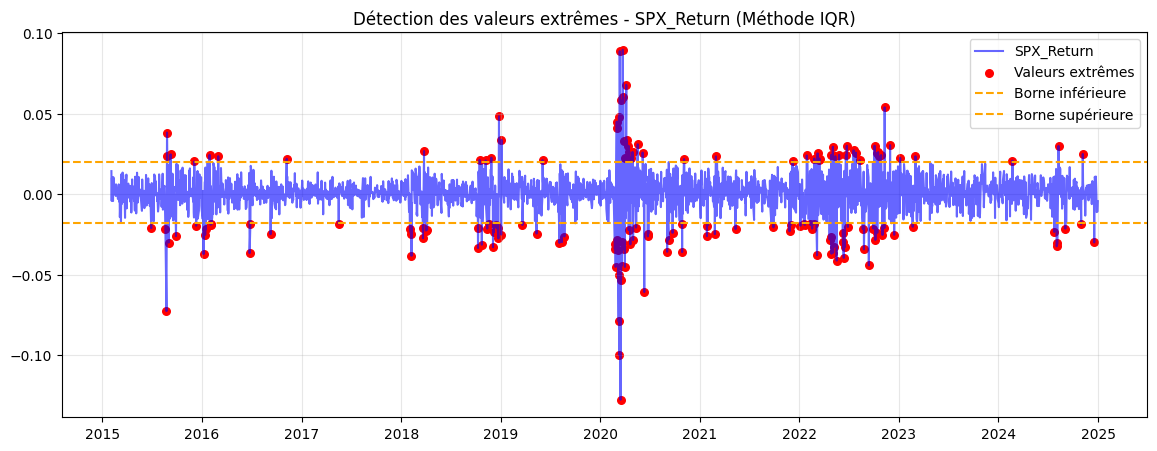

In [29]:
ret = df['SPX_Return']

Q1 = ret.quantile(0.25)
Q3 = ret.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

extremes = (ret < lower_bound) | (ret > upper_bound)
extreme_points = ret[extremes]

print("IQR :", round(IQR, 5))
print("Borne inférieure :", round(lower_bound, 5))
print("Borne supérieure :", round(upper_bound, 5))
print("Nombre de valeurs extrêmes détectées :", extreme_points.shape[0])


# === Visualisation ===
plt.figure(figsize=(14,5))
plt.plot(ret.index, ret, label='SPX_Return', color='blue', alpha=0.6)
plt.scatter(extreme_points.index, extreme_points, color='red', label='Valeurs extrêmes', s=30)
plt.axhline(lower_bound, color='orange', linestyle='--', label='Borne inférieure')
plt.axhline(upper_bound, color='orange', linestyle='--', label='Borne supérieure')
plt.title('Détection des valeurs extrêmes - SPX_Return (Méthode IQR)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [36]:
#Descriptive stats + hypothesis tests pre/during/post covid

ret = df["SPX_Return"].dropna()
pre   = ret.loc["2015-01-01":"2019-12-31"]
covid = ret.loc["2020-03-01":"2020-06-30"]   
post  = ret.loc["2020-07-01":]


def describe(series, name):
    jb_stat, jb_p = stats.jarque_bera(series)
    return pd.Series({
        "N": series.size,
        "Mean": series.mean(),
        "Vol_ann": series.std() * np.sqrt(252),
        "Skew": series.skew(),
        "ExcessKurt": stats.kurtosis(series, fisher=True),
        "JB_p": jb_p
    }, name=name)

summary = pd.concat([
    describe(pre, "Pre-COVID (2015-2019)"),
    describe(covid, "During COVID (2020-03→06)"),
    describe(post, "Post-COVID (2020-07→)")
], axis=1).round(4)


def pair_tests(a, b, label):
    ttest = stats.ttest_ind(a, b, equal_var=False)
    levene = stats.levene(a, b)
    return pd.Series({
        "T_stat": round(ttest.statistic, 3),
        "T_pval": round(ttest.pvalue, 4),
        "Levene_stat": round(levene.statistic, 3),
        "Levene_pval": round(levene.pvalue, 4)
    }, name=label)

tests = pd.concat([
    pair_tests(pre, covid, "Pre vs During"),
    pair_tests(pre, post, "Pre vs Post"),
    pair_tests(covid, post, "During vs Post")
], axis=1)

print(summary)
print(tests)

            Pre-COVID (2015-2019)  During COVID (2020-03→06)  \
N                       1220.0000                    85.0000   
Mean                       0.0004                     0.0006   
Vol_ann                    0.1358                     0.5482   
Skew                      -0.8860                    -0.5921   
ExcessKurt                 7.3115                     2.4599   
JB_p                       0.0000                     0.0000   

            Post-COVID (2020-07→)  
N                       1093.0000  
Mean                       0.0006  
Vol_ann                    0.1683  
Skew                      -0.3464  
ExcessKurt                 1.8187  
JB_p                       0.0000  
             Pre vs During  Pre vs Post  During vs Post
T_stat             -0.0490      -0.4990         -0.0050
T_pval              0.9612       0.6179          0.9962
Levene_stat       336.0170      57.6780        221.0850
Levene_pval         0.0000       0.0000          0.0000


In [ ]:
#Statistiques ADF
def adf_result(series, label):
    series = series.dropna()
    stat, p, lags, nobs, crit, _ = adfuller(series, autolag='AIC')
    return {
        "Période": label,
        "ADF Stat": round(stat, 4),
        "p-value": round(p, 4),
        "Lags": lags,
        "Critique 1%": round(crit['1%'], 4),
        "Critique 5%": round(crit['5%'], 4),
        "Critique 10%": round(crit['10%'], 4),
        "Stationnaire": " Oui" if p < 0.05 else " Non"
    }


results = []
results.append(adf_result(pre, "Pre-COVID (2015–2019)"))
results.append(adf_result(covid, "During COVID (2020-03→06)"))
results.append(adf_result(post, "Post-COVID (2020-07→)"))


adf_table = pd.DataFrame(results).set_index("Période")
display(adf_table)


,ADF Stat,p-value,Lags,Critique 1%,Critique 5%,Critique 10%,Stationnaire
Période,,,,,,,
Pre-COVID (2015–2019),-26.0048,0.0000,1,-3.4357,-2.8639,-2.5680,Oui
During COVID (2020-03→06),-2.7632,0.0637,6,-3.5171,-2.8994,-2.5870,Non
Post-COVID (2020-07→),-7.6648,0.0000,17,-3.4364,-2.8642,-2.5682,Oui


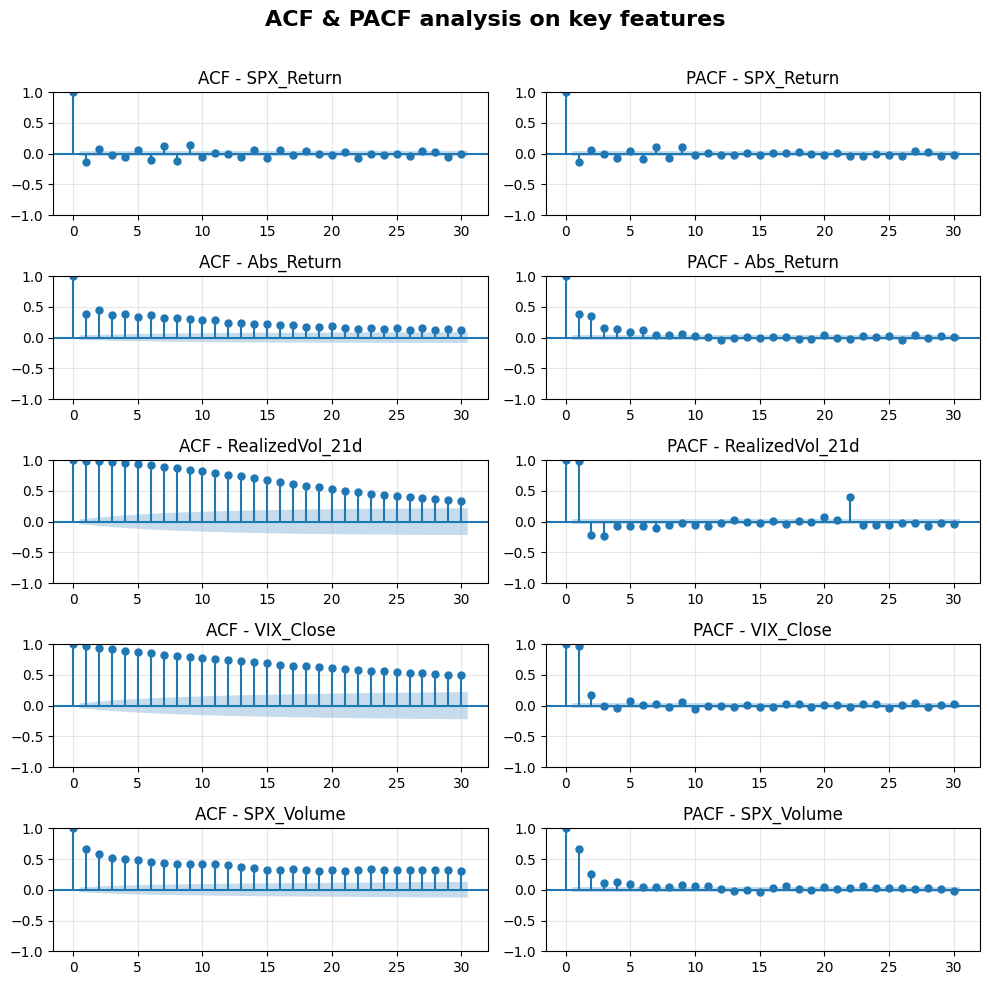

In [41]:
features_to_check = ["SPX_Return", "Abs_Return", "RealizedVol_21d", "VIX_Close", "SPX_Volume"]
lags = 30

fig, axes = plt.subplots(len(features_to_check), 2, figsize=(10, 2*len(features_to_check)))
fig.suptitle("ACF & PACF analysis on key features", fontsize=16, fontweight='bold')

for i, col in enumerate(features_to_check):
    series = df[col].dropna()
    
    # ACF
    plot_acf(series, lags=lags, ax=axes[i, 0])
    axes[i, 0].set_title(f"ACF - {col}", fontsize=12)
    axes[i, 0].grid(alpha=0.3)
    
    # PACF
    plot_pacf(series, lags=lags, ax=axes[i, 1])
    axes[i, 1].set_title(f"PACF - {col}", fontsize=12)
    axes[i, 1].grid(alpha=0.3)

plt.tight_layout(rect=[0,0,1,0.97])
plt.show()


## Interprétation

- **SPX_Return**: Pas d'autocorrélation significative → se comporte comme un bruit blanc (ARIMA(0,0,0)).
- **Abs_Return**: Autocorrélation persistante → regroupement de volatilité → bon candidat pour les modèles de type GARCH.
- **RealizedVol_21d**: Forte autocorrélation → mémoire longue → structure AR ou ARMA probable.
- **VIX_Close**: Autocorrélation moyenne à forte → peut être modélisé avec ARIMA(p,d,q).
- **SPX_Volume**: Motif saisonnier ou persistant potentiel → structure AR ou ARMA possible.

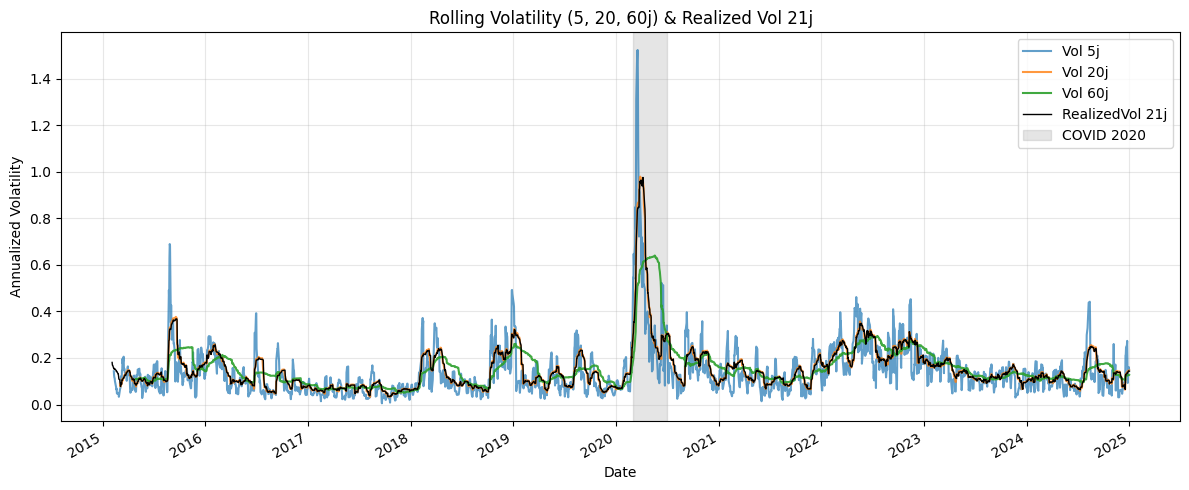

Pre-COVID  (2015–2019): 0.1215 (mean)
Post-COVID (2020–...): 0.159 (mean)
Pre-COVID  (max): 0.368
Post-COVID (max): 0.349

=== Volatility Peaks (Top 2%) ===
Date
2020-04-06    0.975552
2020-03-30    0.964436
2020-03-26    0.958766
2020-03-27    0.954185
2020-04-01    0.953274
2020-03-31    0.947114
2020-04-02    0.942875
2020-04-03    0.938969
2020-04-07    0.937905
2020-04-08    0.929412
Name: RealizedVol_21d, dtype: float64


In [42]:
ret = df['SPX_Return'].dropna()
rolling_vol_5  = ret.rolling(5).std() * np.sqrt(252)
rolling_vol_20 = ret.rolling(20).std() * np.sqrt(252)
rolling_vol_60 = ret.rolling(60).std() * np.sqrt(252)

fig, ax = plt.subplots(figsize=(12,5))
rolling_vol_5.plot(ax=ax, label='Vol 5j', alpha=0.7)
rolling_vol_20.plot(ax=ax, label='Vol 20j', alpha=0.8)
rolling_vol_60.plot(ax=ax, label='Vol 60j', alpha=0.9)
df['RealizedVol_21d'].plot(ax=ax, label='RealizedVol 21j', color='black', linewidth=1)

ax.axvspan(pd.to_datetime("2020-03-01"), pd.to_datetime("2020-06-30"), color='grey', alpha=0.2, label='COVID 2020')
ax.set_title("Rolling Volatility (5, 20, 60j) & Realized Vol 21j", fontsize=12)
ax.set_ylabel("Annualized Volatility")
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


pre_vol = df.loc["2015-01-01":"2019-12-31", "RealizedVol_21d"].dropna()

post_vol = df.loc["2020-07-01":, "RealizedVol_21d"].dropna()


print("Pre-COVID  (2015–2019):", round(pre_vol.mean(), 4), "(mean)")
print("Post-COVID (2020–...):", round(post_vol.mean(), 4), "(mean)")
print("Pre-COVID  (max):", round(pre_vol.max(), 4))
print("Post-COVID (max):", round(post_vol.max(), 4))

threshold = df['RealizedVol_21d'].quantile(0.98)
peaks = df[df['RealizedVol_21d'] > threshold]

print("\n=== Volatility Peaks (Top 2%) ===")
print(peaks['RealizedVol_21d'].sort_values(ascending=False).head(10))


## Mesures de Volatilité

### Volatilité de Parkinson

La volatilité de Parkinson utilise les prix High et Low pour estimer la volatilité :

σP = √(1/(4n ln 2) × Σ ln(Hi/Li)²)

Où :
- n = nombre d'observations
- Hi = prix le plus haut de la période i
- Li = prix le plus bas de la période i
- ln 2 ≈ 0.693

Avantages : Plus efficace que la volatilité basée sur les prix de clôture car elle capture les mouvements intra-journaliers.

### ATR (Average True Range)

L'ATR mesure la volatilité en calculant la moyenne des True Range sur une période donnée :

TR = max(High - Low, |High - Close_précédent|, |Low - Close_précédent|)

ATR = Moyenne mobile du TR sur n périodes

Utilisation : Indicateur populaire en analyse technique pour mesurer la volatilité du marché et ajuster les stops.

### Volatility of Volatility (Vol de la Vol)

Vol(σ) = Écart-type(σt) sur une période glissante

Utile pour détecter les régimes de volatilité changeants et les périodes de stress du marché.

### Range Normalisé

Le range normalisé exprime l'amplitude des prix en proportion du niveau de prix :

Range Normalisé = (High - Low) / Prix_référence

Où Prix_référence peut être : Close, Open, ou (High + Low)/2

Avantage : Permet de comparer la volatilité entre différents niveaux de prix ou différents actifs.

In [54]:
# Compute range-based volatility features: Parkinson, ATR, vol-of-vol, normalized range.

def build_range_vol_features(df, high_col="SPX_High", low_col="SPX_Low", close_col="SPX_Close",
                             w_parkinson=20, w_atr=14, w_vov=20):
    
    # Validate required columns
    required_cols = {high_col, low_col, close_col}
    if not required_cols.issubset(df.columns):
        missing = required_cols - set(df.columns)
        raise KeyError(f"Missing columns: {missing}")

    out = df.copy()
    H = out[high_col].astype(float)
    L = out[low_col].astype(float)
    C = out[close_col].astype(float)

    # Parkinson volatility (1-day and rolling window)
    k = 1.0 / (4.0 * np.log(2.0))
    log_hl_ratio = np.log(H / L).replace([np.inf, -np.inf], np.nan)
    
    out["park_sigma_1d"] = np.sqrt(k) * log_hl_ratio.abs()
    out["park_sigma_win"] = np.sqrt(
        (k / w_parkinson) * (log_hl_ratio ** 2).rolling(w_parkinson).sum()
    )

    # True Range & ATR (simple moving average over w_atr periods)
    prev_close = C.shift(1)
    tr_components = pd.DataFrame({
        'hl': H - L,
        'hc': (H - prev_close).abs(),
        'lc': (L - prev_close).abs()
    })
    
    out["TR"] = tr_components.max(axis=1)
    out[f"ATR_{w_atr}"] = out["TR"].rolling(w_atr).mean()

    # Raw range and normalized range
    out["range_raw"] = H - L
    out["range_norm"] = (H - L) / C.replace(0, np.nan)

    # Volatility of volatility (on Parkinson volatility)
    out[f"vol_of_vol_park_{w_vov}"] = out["park_sigma_win"].rolling(w_vov).std()

    # Vol-of-vol on RealizedVol_21d if available
    if "RealizedVol_21d" in out.columns:
        out[f"vol_of_vol_realized_{w_vov}"] = out["RealizedVol_21d"].rolling(w_vov).std()

    return out.dropna()


df_feat = build_range_vol_features(df, w_parkinson=20, w_atr=14, w_vov=20)

# Select features to display
cols_display = [
    "park_sigma_1d", 
    "park_sigma_win", 
    "ATR_14", 
    "range_raw", 
    "range_norm",
    "vol_of_vol_park_20"
]

# Add vol_of_vol_realized if available
if "vol_of_vol_realized_20" in df_feat.columns:
    cols_display.append("vol_of_vol_realized_20")

# Display summary statistics as table
print("Range-Based Volatility Features - Summary Statistics".center(80))

summary_df = df_feat[cols_display].describe().T
print(summary_df.round(4).to_string())


              Range-Based Volatility Features - Summary Statistics              
                         count     mean      std     min      25%      50%      75%       max
park_sigma_1d           2400.0   0.0066   0.0049  0.0009   0.0034   0.0052   0.0081    0.0506
park_sigma_win          2400.0   0.0072   0.0040  0.0022   0.0047   0.0060   0.0091    0.0340
ATR_14                  2400.0  41.8943  26.2003  8.4093  20.1156  37.8132  55.9780  198.2671
range_raw               2400.0  37.0545  28.3445  3.7900  16.5000  29.1600  48.5000  218.9600
range_norm              2400.0   0.0110   0.0082  0.0015   0.0057   0.0087   0.0135    0.0808
vol_of_vol_park_20      2400.0   0.0009   0.0010  0.0001   0.0004   0.0006   0.0011    0.0082
vol_of_vol_realized_20  2400.0   0.0227   0.0277  0.0019   0.0089   0.0149   0.0265    0.2531
